In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
import sys

In [5]:
print(f"python version : {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}",)

print("np version : ", np.__version__)
print("pd version : ",pd.__version__)

python version : 3.8.10
np version :  1.24.3
pd version :  2.0.3


In [6]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'CART.ipynb',
 'data',
 'README.md',
 'Untitled.ipynb',
 'venv']

In [7]:
os.listdir("data/h&m/")

['articles.parquet', 'customers.parquet', 'transactions_train.csv']

Goal: predict article for each customer for next 7 days

In [10]:
interaction_df = pd.read_csv("data/h&m/transactions_train.csv")
user_df = pd.read_parquet("data/h&m/customers.parquet")
item_df = pd.read_parquet("data/h&m/articles.parquet")

## configs

In [17]:
date_col = 't_dat'
user_col = 'customer_id'
item_col = 'article_id'

In [12]:
interaction_df[date_col] = pd.to_datetime(interaction_df[date_col], format='%Y-%m-%d')
print(interaction_df.shape)
interaction_df.head()

(31788324, 5)


t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  
0  0.050831                 2  
1  0.030492                 2  
2  0.015237                 2  
3  0.016932                 2  
4  0.016932                 2

In [20]:
interaction_df.describe()

t_dat    article_id         price  \
count                       31788324  3.178832e+07  3.178832e+07   
mean   2019-09-15 17:27:46.894452992  6.962272e+08  2.782927e-02   
min              2018-09-20 00:00:00  1.087750e+08  1.694915e-05   
25%              2019-03-28 00:00:00  6.328030e+08  1.581356e-02   
50%              2019-08-25 00:00:00  7.145820e+08  2.540678e-02   
75%              2020-03-29 00:00:00  7.865240e+08  3.388136e-02   
max              2020-09-22 00:00:00  9.562170e+08  5.915254e-01   
std                              NaN  1.334480e+08  1.918113e-02   

       sales_channel_id  
count      3.178832e+07  
mean       1.704028e+00  
min        1.000000e+00  
25%        1.000000e+00  
50%        2.000000e+00  
75%        2.000000e+00  
max        2.000000e+00  
std        4.564786e-01

In [13]:
print(user_df.shape)
user_df.head()

(1371980, 7)


customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  NaN     NaN   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  NaN     NaN   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  NaN     NaN   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  NaN     NaN   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

In [14]:
print(item_df.shape)
item_df.head()

(105542, 25)


article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid                 10             White  ...   
2                    Stripe                 11         Off White  ...   
3                     Solid                  9             Black  ...   
4                     Solid                 10             White  ...   

   department_name index_code        index_name index_group_no  \
0     Jersey Basic          A        Ladieswear              1   
1     Jersey Basic          A        Ladieswear              1   
2     Jersey Basic          A        Ladieswear              1   
3   Clean Lingerie          B  Lingeries/Tights              1   
4   Clean Lingerie          B  Lingeries/Tights              1   

   index_group_name section_no            section_name garment_group_no  \
0        Ladieswear         16  Womens Everyday Basics             1002   
1        Ladieswear         16  Womens Everyday Basics             1002   
2        Ladieswear         16  Womens Everyday Basics             1002   
3        Ladieswear         61         Womens Lingerie             1017   
4        Ladieswear         61         Womens Lingerie             1017   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1        Jersey Basic            Jersey top with narrow shoulder straps.  
2        Jersey Basic            Jersey top with narrow shoulder straps.  
3   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  
4   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  

[5 rows x 25 columns]

# Data Preprocessing

# Modeling

## Item2Vec

In [21]:
import gensim

In [38]:
train_df = interaction_df.loc[interaction_df['t_dat'] < '2020-01-01'].copy()
test_df = interaction_df.loc[interaction_df['t_dat'] < '2020-01-01'].copy()

In [23]:
train_df.head()

t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  
0  0.050831                 2  
1  0.030492                 2  
2  0.015237                 2  
3  0.016932                 2  
4  0.016932                 2

In [48]:
user_seq = train_df.groupby(user_col)[item_col].apply(list)
user_seq_df = pd.DataFrame(user_seq).rename(columns={item_col:"seq_list"})
tr_seq_df = train_df.drop_duplicates(user_col, keep='first')
tr_seq_df = tr_seq_df.merge(user_seq_df, on=user_col)

In [57]:
tr_seq_df['n_seq'] = tr_seq_df['seq_list'].str.len()

array([[<Axes: title={'center': 'n_seq'}>]], dtype=object)

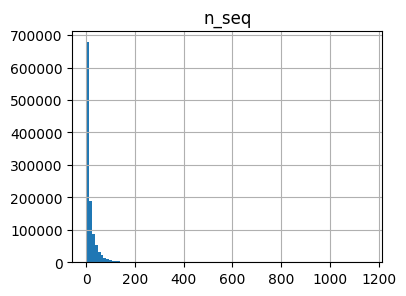

In [68]:
tr_seq_df[['n_seq']].hist(bins=100, figsize=(4, 3))

In [70]:
tr_seq_df.head()

t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
2 2018-09-20  00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...   688873012   
3 2018-09-20  0008968c0d451dbc5a9968da03196fe20051965edde741...   531310002   
4 2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   501820043   

      price  sales_channel_id  \
0  0.050831                 2   
1  0.015237                 2   
2  0.030492                 1   
3  0.022525                 2   
4  0.016932                 2   

                                            seq_list  n_seq  
0       [663713001, 541518023, 663713001, 578020002]      4  
1  [505221004, 685687003, 685687004, 685687001, 5...    110  
2  [688873012, 501323011, 598859003, 688873020, 6...     26  
3  [531310002, 529841001, 662980002, 496111003, 5...     38  
4  [501820043, 501820043, 674681001, 671505001, 6...     47

In [71]:
tr_sequences = tr_seq_df['seq_list'].tolist()

In [75]:
from gensim.models import Word2Vec
import datetime

model = Word2Vec(vector_size = 100, #
                 workers = 4, # s
                 sg = 1, # 1 = Skip-gram, else = CBOW
                 hs = 0, # Hierachical softmax = 1, else Negative sampling
                 negative = 5, 
                 window = 9999999)

Time passed: 0:00:00.004656


In [86]:
model.build_vocab(tr_sequences, progress_per=10_000)
model.train(tr_sequences, total_examples=model.corpus_count,
           epochs=10)

In [ ]:
model.save('trained_model/item2vec.model')

In [ ]:
item2vec = Word2Vec(vector_size=100, workers=4, sg=1, hs=0, negative=5, window=9999999)
model = item2vec.load('trained_model/item2vec.model')

In [ ]:
item_vectors = model.wv
item_vectors[item_id] # get item_id's item vector

In [84]:
model.corpus_count == len(tr_seq_df)

True

In [82]:
model.corpus_total_words == tr_seq_df['n_seq'].sum()

True

In [ ]:
import umap
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [ ]:
user_seq = test_df.groupby(user_col)[item_col].apply(list)
user_seq_df = pd.DataFrame(user_seq).rename(columns={item_col:"seq_list"})
test_seq_df = test_df.drop_duplicates(user_col, keep='first')
test_seq_df = test_seq_df.merge(user_seq_df, on=user_col)

test_seq_df['true_y'] = test_seq_df.apply(lambda x: x[-1])

In [ ]:

for row in test_seq_df.iter_tuple():
    row = getattr()